# Bodyfat Calculator

Group member: Hongyi Jin, Wanwan Su, Yingjing Jiang

Body fat percentage, a measure of obesity, plays an important role in various health outcomes such as life expectancy, prognosis for disease, healthcare costs, and the general well-being of individuals. Body fat percentage is helpful for people to have a basic knowledge of their health condiction. However, accurate measurement of body fat is often costly and inconvenient and it is desirable to have easy methods of estimating body fat that are not inconvenient/costly. 

In this module, we are going to come up with a simple and robust method to estimate percentage of body fat based on a real data set of 252 men with measurements of their percentage of body fat and other body measurements.

## 1.Data Processing

### 1.1 Data Description

In [1]:
library(car)
library(leaps)
# library(faraway)
library(glmnet)
library(repr)
library(dplyr)
library(ggplot2)

bf <- read.csv('~/Desktop/628Data Science Practice/module1/BodyFat.csv', header = TRUE)
#bf <- read.csv('D:\\WISC\\STAT 628\\BodyFat.csv', header = TRUE)
bf <- bf[ , -1]
names(bf) <- tolower(names(bf))

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-13


Attaching package: ‘dplyr’

The following object is masked from ‘package:car’:

    recode

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



The data is a real collection of 252 men with measurements of their percentage of body fat and various body circumference measurements. There are totally 16 variables, including Body Density and Body Fat Percentage.

We first check the distribution of each variables in the data. Most variables distribute normally. However, several variables have some outliers faraway from other data points. We find that **patient 39** has a weight of 363 lbs and his circumferences of *biceps, knee, hip, thigh, abdomen, chest and neck*  are far larger than anyone else. Another fun fact is that **patient 182** has 0 bodyfat with smallest circumferences of *abdomen, hip, thigh, chest, adiposity and weight* amoung all the patients.  

We consider these two patients as potential outliers in the data.

ankle 31, 86 large than expected but still within threshold

### 1.2 Verify Data

#### Bodyfat

The body fat is calculated from Siri's equation: $$Body fat = \frac{495}{Density} - 450$$ 
We verify body fat data by density and plot a picture of body fat in the data vs calculated body fat. It's obvious that several body fat data points are quite different from the calculated one. 

There are 5 points whose differences between two types of body fat are larger than 2. We compare their body figures with other patients with similar body fat. We tend to keep the body fat in the data of **patient 48, 76, 96 and 216**. The difference in the other variables are not enough to say that the body fat value in the data is wrong. The **patient 182** has a 0 body fat in the data and -3% calculated body fat. Based on the fact this patient also has relatively smaller body figure than other people, the data of this patient may have some error or the patient is in some special condition. Thus this patient is not suitable for the model we are going to build. We exclude this point in our model.

Then we delete the density in the data, as it's figure that very hard to obtain by people themselves and impossible to use in the calculator.  

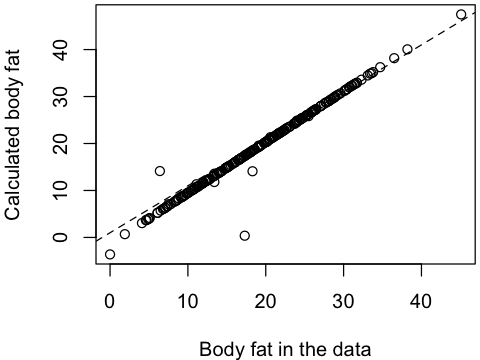

In [2]:
bdfat <- 495/bf$density - 450
options(repr.plot.width=4, repr.plot.height=3)
par(mar = c(4, 4, 0.2, 0.2))
plot(bf$bodyfat, bdfat, xlab = 'Body fat in the data', ylab = 'Calculated body fat')
abline(1,1, lty = 2)

In [3]:
# options(repr.plot.width=4, repr.plot.height=4)
# hist(bdfat - bf$bodyfat, breaks = 20, xlab = 'The difference of two body fat', main = 'Histgram of difference')
sp_point <- which(abs(bdfat - bf$bodyfat) > 2)
sp_data <- bf[sp_point, ] 
sp_data <- cbind(cal_bodyfat = bdfat[sp_point], sp_data)
sp_data

,cal_bodyfat,bodyfat,density,age,weight,height,adiposity,neck,chest,abdomen,hip,thigh,knee,ankle,biceps,forearm,wrist
48,14.1350211,6.4,1.0665,39,148.50,71.25,20.6,34.6,89.8,79.5,92.7,52.7,37.5,21.9,28.8,26.8,17.9
76,14.0915057,18.3,1.0666,61,148.25,67.50,22.9,36.0,91.6,81.8,94.8,54.5,37.0,21.4,29.3,27.0,18.3
96,0.3684833,17.3,1.0991,53,224.50,77.75,26.1,41.1,113.2,99.2,107.5,61.7,42.3,23.2,32.9,30.8,20.4
182,-3.6116873,0.0,1.1089,40,118.50,68.00,18.1,33.8,79.3,69.4,85.0,47.2,33.5,20.2,27.7,24.6,16.5
216,47.4874372,45.1,0.9950,51,219.00,64.00,37.6,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4


#### Adiposity(BMI)
The adiposity is calculated by the weight and height. By simillar process like above, we find **patient 42** has wrong height data. We replace the height of **patient 42** with the height calculated by his weight and adiposity. After this, the value of this patient is reasonable. The relatively small data size is also one reason that we keep this patient rather than delete him.


In [4]:
bmi <-  (bf$weight*0.454)/(bf$height*2.54/100)^2
# options(repr.plot.width=7, repr.plot.height=4)
# hist(bmi - bf$adiposity, breaks = 20)
sp_point1 <- which(abs(bmi - bf$adiposity) > 5)
sp_data1 <- cbind(bf[sp_point1 , 1:6], bmi = bmi[sp_point1], bf[sp_point1, 7:16])
sp_data1
# 42 wrong height
bf[42, ]$height <- round(sqrt((bf[42, ]$weight*0.454)/bf[42, ]$adiposity)*100/2.54, 2)

bf <- bf[ , -2]

,bodyfat,density,age,weight,height,adiposity,bmi,neck,chest,abdomen,hip,thigh,knee,ankle,biceps,forearm,wrist
42,31.7,1.025,44,205,29.5,29.9,165.7671,36.6,106,104.3,115.5,70.6,42.5,23.7,33.6,28.7,17.4


### 1.3 Diagnose Data

We then build a linear model to check the outliers. We can see that **patient 39, 86, 221** have very large cook's distance than other points. **Patient 39** has extremly large weight. We think he should be fitted by some special model. **Patient 86** has relatively large ankle circumference than people with similar body fat. **Patient 221** has relatively large abdomen circumference than people with similar body fat. Thus we exclude **patient 39** and keep other two in the data.


To summarize, we exclued **patient 39, 182** in our model.


Call:
lm(formula = bodyfat ~ ., data = bf[-182, ])

Residuals:
     Min       1Q   Median       3Q      Max 
-10.1404  -2.6560  -0.1829   2.8760   9.2129 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -45.960519  36.614590  -1.255  0.21063    
age           0.059805   0.029831   2.005  0.04613 *  
weight       -0.165638   0.100566  -1.647  0.10088    
height        0.440213   0.507502   0.867  0.38660    
adiposity     0.757834   0.732658   1.034  0.30203    
neck         -0.437262   0.217818  -2.007  0.04584 *  
chest        -0.057762   0.098941  -0.584  0.55991    
abdomen       0.867115   0.085422  10.151  < 2e-16 ***
hip          -0.209335   0.136098  -1.538  0.12536    
thigh         0.225928   0.136029   1.661  0.09807 .  
knee         -0.005154   0.229205  -0.022  0.98208    
ankle         0.124407   0.208170   0.598  0.55066    
biceps        0.160697   0.159800   1.006  0.31563    
forearm       0.396265   0.185984   2.131  0.03415 *  
wris


No Studentized residuals with Bonferonni p < 0.05
Largest |rstudent|:
     rstudent unadjusted p-value Bonferonni p
221 -2.822621          0.0051714           NA

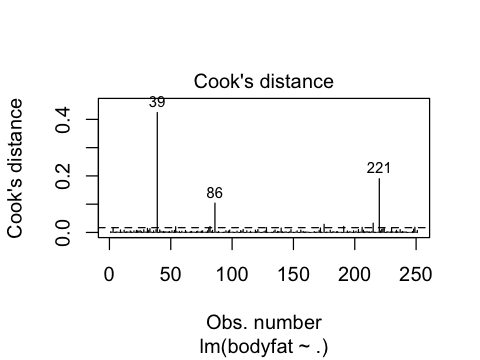

In [5]:
fit1 <- lm(bodyfat ~ ., data = bf[-182, ])
summary(fit1)
plot(fit1, which = 4)
abline(h = 4/(nrow(bf) - ncol(bf)), lty = 2)
outlierTest(fit1)

In [6]:
bf[c(39, 86, 221), ]

,bodyfat,age,weight,height,adiposity,neck,chest,abdomen,hip,thigh,knee,ankle,biceps,forearm,wrist
39,33.8,46,363.15,72.25,48.9,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4
86,25.8,67,167.00,67.50,26.0,36.5,98.9,89.7,96.2,54.7,37.8,33.7,32.4,27.7,18.2
221,12.7,54,153.25,70.50,24.5,38.5,99.0,91.8,96.2,57.7,38.1,23.9,31.4,29.9,18.9


## 2.Variable Selection

### 2.1 Background

There is a method to calculate body density accurately based on determining body volume by underwater submersion. But it is hard for doctors who want to and easily quickly determine a patient’s body fat percentage based on commonly available measurements to use.

Accordind to some popular books, estimating the percentage of body fat is at least a part, considered to assess body health. The books show that age, skin-fold measurements and body circumference measurements are used to estimate body fat. Additionally, online body fat percentage calculators show that among age, skin-fold measurements and body circumference measurements, "AGE", "WEIGHT","HEIGHT", "WRIST",HIP" are often used.


### 2.2 Stepwise selection

We check the p-value of each variable in the full model, find that many vairbles are not significant in the model. In order to get a simple model, we first use stepwise method with AIC and BIC criteria to select variable.

In [7]:
summary(fit1)


Call:
lm(formula = bodyfat ~ ., data = bf[-182, ])

Residuals:
     Min       1Q   Median       3Q      Max 
-10.1404  -2.6560  -0.1829   2.8760   9.2129 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -45.960519  36.614590  -1.255  0.21063    
age           0.059805   0.029831   2.005  0.04613 *  
weight       -0.165638   0.100566  -1.647  0.10088    
height        0.440213   0.507502   0.867  0.38660    
adiposity     0.757834   0.732658   1.034  0.30203    
neck         -0.437262   0.217818  -2.007  0.04584 *  
chest        -0.057762   0.098941  -0.584  0.55991    
abdomen       0.867115   0.085422  10.151  < 2e-16 ***
hip          -0.209335   0.136098  -1.538  0.12536    
thigh         0.225928   0.136029   1.661  0.09807 .  
knee         -0.005154   0.229205  -0.022  0.98208    
ankle         0.124407   0.208170   0.598  0.55066    
biceps        0.160697   0.159800   1.006  0.31563    
forearm       0.396265   0.185984   2.131  0.03415 *  
wris

We write a function to perform backward and forward stepwise selection with AIC and BIC creitera on certain data.

In [8]:
regModel <- function(bf_data){
  result <- list()
  fit2 <- lm(bodyfat ~ ., data = bf_data) # without 2 outliers
  fit2_AIC <- step(fit2, k = 2, direction = 'backward', trace = F)
  fit2_BIC <- step(fit2, k = log(nrow(bf_data)), direction = 'backward', trace = F)
  fit_base <- lm(bodyfat ~ 1, data =  bf_data)
  base_AIC <- step(fit_base, scope = list(lower = ~ 1, upper = fit2), 
                   direction = 'forward', trace = F)
  base_BIC <- step(fit_base, scope = list(lower = ~ 1, upper = fit2), 
                   k = log(nrow(bf_data)), direction = 'forward', trace = F) 
  result <- list()
  result[['fit']] = fit2
  result[['back_AIC']] = fit2_AIC
  result[['back_BIC']] = fit2_BIC
  result[['for_AIC']] = base_AIC
  result[['for_BIC']] = base_BIC
  return(result)
}
sumReg <- function(fun, reg, n = length(reg)){
    out <- data.frame()
  for(i in 1:n){
    tmp <- data.frame(t(round(fun(reg[[i]]), 4)))
    out <- bind_rows(out, tmp)
  }
    row.names(out) <- names(reg)
    return(out)
}

Rsqr <- function(reg){
    tmp <- data.frame()
    for(i in 1:length(reg)){
        out <- data.frame("R square" =  round(summary(reg[[i]])$r.squared, 4), 
                          "adj R square" = round(summary(reg[[i]])$adj.r.squared, 4), 
                          "number of var" = length(reg[[i]]$coefficients)
                         )
        tmp <- rbind(tmp, out)
    }
    row.names(tmp) <- names(reg)
    return(tmp)
}

After the stepwise selection, we first use the r square to evaluate how well the response variable is explained by the model. It's obvious that though the number of variables can be reduced a lot, the r squares are not effected as much. So all the models are valid. We plan to choose the forward BIC model which contains weightem abdomen and wrist, based on our goal of simplicity.

In [9]:
bf_data <- bf[c(-39, -182), ]
reg_with_bmi <- regModel(bf_data)
Rsqr(reg_with_bmi)
sumReg(coef, reg_with_bmi)

,R.square,adj.R.square,number.of.var
fit,0.7499,0.7349,15
back_AIC,0.7457,0.7373,9
back_BIC,0.7382,0.7328,6
for_AIC,0.7403,0.7339,7
for_BIC,0.7314,0.7282,4


,X.Intercept.,age,weight,height,adiposity,neck,chest,abdomen,hip,thigh,knee,ankle,biceps,forearm,wrist
fit,-19.9976,0.0680,-0.0804,0.1746,0.6433,-0.3624,-0.1497,0.8200,-0.1666,0.1591,-0.0571,0.1351,0.1580,0.2340,-1.6931
back_AIC,4.5490,0.0612,NA,NA,0.6029,-0.3732,-0.2138,0.7901,-0.1668,NA,NA,NA,NA,0.2719,-1.7621
back_BIC,-2.5658,0.0798,NA,NA,0.5403,NA,-0.2232,0.7052,NA,NA,NA,NA,NA,NA,-2.1101
for_AIC,-28.1821,0.0562,-0.0988,NA,NA,NA,NA,0.8164,NA,0.1688,NA,NA,0.2194,NA,-1.6631
for_BIC,-23.4137,NA,-0.0854,NA,NA,NA,NA,0.8859,NA,NA,NA,NA,NA,NA,-1.3318


However, due to the exsitence of BMI, the multi-colinearity can be severe. We use VIF to detect the multi-colinearity in the model. We can see that after variable selection, the multi-colinearity has already been reduced a lot. Then we use ridge regression base on the model we selected to see whether we can do any further improvement.

In [10]:
sumReg(vif, reg_with_bmi)

fit_BIC <- lm(bodyfat ~ abdomen + weight + wrist, data = bf_data)

lambda <- seq(0, 10, length.out = 50)
bf_x <- model.matrix(fit_BIC)[ , -1]
bf_y <- as.matrix(bf_data[ , 1])
fit_r <- glmnet(bf_x, bf_y, alpha = 1, lambda = lambda)
fit_r_cv <- cv.glmnet(bf_x, bf_y, alpha = 1)
best_lam <- fit_r_cv$lambda.min

pred_r <- predict(fit_r, s = best_lam, newx = bf_x, type = 'link')

out <- data.frame(lm = mean(fit_BIC$residuals^2),
                 ridge = mean((pred_r - bf_y)^2))
row.names(out) <- 'MSE'
out

,age,weight,height,adiposity,neck,chest,abdomen,hip,thigh,knee,ankle,biceps,forearm,wrist
fit,2.2549,124.9698,28.5814,92.7699,3.9178,11.0770,12.2188,12.2575,7.2042,4.4092,1.8303,3.3906,2.4178,3.1964
back_AIC,1.7036,NA,NA,9.0873,3.4659,8.1577,11.0512,6.2874,NA,NA,NA,NA,2.1349,2.6011
back_BIC,1.1516,NA,NA,8.3743,NA,7.8126,8.2839,NA,NA,NA,NA,NA,NA,1.7139
for_AIC,2.0435,11.8219,NA,NA,NA,NA,6.8539,NA,4.7008,NA,NA,2.8251,NA,2.6352
for_BIC,NA,5.6125,NA,NA,NA,NA,4.2061,NA,NA,NA,NA,NA,NA,2.0623


,lm,ridge
MSE,15.57638,15.57895


### 2.3 Mallow's cp

For Mallow's Cp method, we select the subsets with minimum Cp values within different variable number $p$($p<k$, $k$ predictors in all) first. Then, we compare those Cp values with $p+1$ to get the best subset for us.

In [11]:
dat=read.csv("~/Desktop/628/module 1/BodyFat.csv")[,-1]
dat=dat[,-2]

m2=lm(BODYFAT~.,data=dat[-c(39,42),])

X=model.matrix(m2)[,-1]
Y=dat[-c(39,42),1]
library(leaps) # for leaps()
library(faraway) # for Cpplot()
g=leaps(X,Y,nbest=1)
layout(1)
Cpplot(g)

Warning message in file(file, "rt"):
“cannot open file '/Users/wanwansu/Desktop/628/module 1/BodyFat.csv': No such file or directory”

ERROR: Error in file(file, "rt"): cannot open the connection


According to the figure, we can find that the model with predictor 1, 3, 6, 7, 13 and 14 is very close to the line($Cp=p+1$), and doesn't have too many predictors. We think it is the best choice for us.

In [12]:
cp.choice=c(2,4,7,8,14,15) 
model.cp=lm(BODYFAT~.,data=dat[-c(39,42),c(1,cp.choice)])
summary(model.cp)
print("cp_AIC:")
AIC(model.cp)
print("cp_BIC:")
BIC(model.cp)

MSE=sum((Y-predict(model.cp,newdata=dat[-c(39,42),-1]))^2)/250
print("cp_MSE")
MSE

ERROR: Error in is.data.frame(data): object 'dat' not found


AIC, BIC and MSE are shown above and they are small comparing with other models.

### 2.4 LASSO

[1] 0.4210889

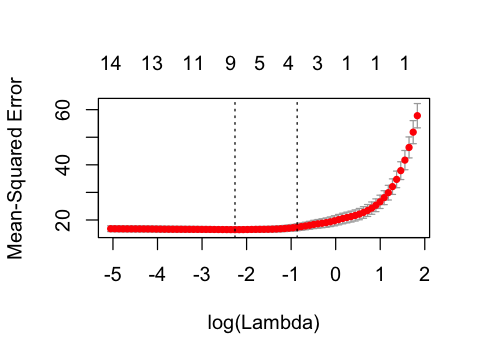

In [17]:
fit_lasso <- cv.glmnet(as.matrix(bf_data[,-1]),bf_data$bodyfat,family = "gaussian", type.measure = "deviance")
fit_lasso$lambda.1se
plot(fit_lasso)

In [14]:
fit.lasso <- glmnet(as.matrix(bf_data[,-1]),bf_data$bodyfat,family = "gaussian", lambda = 0.507203045204555, alpha = 1)
bodyfat_pre <- predict(fit.lasso, newx = as.matrix(bf_data[,-1]))
mse.lasso <- sum((bodyfat_pre-bf_data$bodyfat)^2)/250
mse.lasso
coef(fit.lasso)

[1] 16.78576

15 x 1 sparse Matrix of class "dgCMatrix"
                      s0
(Intercept) -10.65293708
age           0.01274349
weight        .         
height       -0.26230367
adiposity     .         
neck          .         
chest         .         
abdomen       0.59955118
hip           .         
thigh         .         
knee          .         
ankle         .         
biceps        .         
forearm       .         
wrist        -0.43549909

Using the method of cross validation, the best lambda value is selected. With the lambda, we get the selected model:$bodyfat = -17.18118276 + 0.02178266 \times age - 0.14059051\times height + 0.59434639\times adoman - 0.54395699\times wrist$. The mean square error of the model is $16.9163567306706$.

## 3.Statistical Model

### 3.1 Simple Linear Regression

### 3.2 Ridge Regression

In [ ]:
fit_BIC <- lm(bodyfat ~ abdomen + weight + wrist, data = bf_data)


lambda <- seq(0, 10, length.out = 50)
bf_x <- model.matrix(fit_BIC)[ , -1]
bf_y <- as.matrix(bf_data[ , 1])
fit_r <- glmnet(bf_x, bf_y, alpha = 1, lambda = lambda)
fit_r_cv <- cv.glmnet(bf_x, bf_y, alpha = 1)
best_lam <- fit_r_cv$lambda.min

newx_r <- as.matrix(bf_test[ , c(8, 3, 15)])
newx <- bf_test[ , c(3, 8, 15)]
newy <- bf_test[ , 1]
pred_r <- predict(fit_r, s = best_lam, newx = newx_r, type = 'link')

print(mean((pred_r - newy)^2))
print(mean((pred_lm - newy)^2))
# not enough proof for improvement

predict(fit_r, s = best_lam, newx = newx_r, type = 'coefficients')
coef(fit_BIC)

### 3.3 Model Diagnose

## 4.Summary